# Bone Fracture Detection using YOLOv8

This Jupyter Notebook explores the application of deep learning for bone fracture detection using a comprehensive X-ray image dataset.  The dataset is specifically designed for computer vision projects and aims to facilitate the development and evaluation of automated bone fracture detection algorithms.

## About the Dataset

The dataset encompasses X-ray images categorized into several classes, each representing a specific type of bone fracture within the upper extremities. These classes include:

*   Elbow Positive
*   Fingers Positive
*   Forearm Fracture
*   Humerus Fracture
*   Shoulder Fracture
*   Wrist Positive

Each image is annotated with either bounding boxes or pixel-level segmentation masks, precisely indicating the location and extent of the detected fracture. These annotations are crucial for training and evaluating bone fracture detection algorithms, particularly object detection models.

This dataset provides a valuable resource for researchers and developers working on automated fracture detection. Its diverse range of fracture classes enables the training of robust models capable of accurately identifying fractures in various regions of the upper extremities. The ultimate goal of this dataset is to accelerate the development of computer vision solutions for automated fracture detection, thereby contributing to advancements in medical diagnostics and improved patient care.

**When using this dataset for your research, please cite it using the following DOI:** 10.13140/RG.2.2.14400.34569

**You can also find the dataset on ResearchGate:** [https://www.researchgate.net/publication/382268240_Bone_Fracture_Detection_Computer_Vision_Project](https://www.researchgate.net/publication/382268240_Bone_Fracture_Detection_Computer_Vision_Project)

## Imports

In [39]:
from tqdm.notebook import tqdm

import glob
import pathlib
import opendatasets as od
import os
from dotenv import load_dotenv

import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
tf.config.list_physical_devices('GPU'), tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

## Download datasets

In [40]:
# Loading kaggle keys
load_dotenv()

True

In [41]:
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [42]:
from hydra import initialize, compose
from omegaconf import OmegaConf
from hydra import main
# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/BoneFractureYolo8/train/


In [43]:

if len(os.listdir(cfg.DATASET.DATASET_DIR)) == 0:
    # Download the dataset
    od.download(dataset_id_or_url=cfg.DATASET.BONE_FRACTURE_DETECTION_DATASET_URL,
                data_dir=cfg.DATASET.DATASET_DIR)

## Loading Images

In [44]:
CLASS_NAMES = ['elbow positive',
               'fingers positive',
               'forearm fracture',
               'humerus fracture',
               'humerus',
               'shoulder fracture',
               'wrist positive']

class_mapping = dict(zip(range(len(CLASS_NAMES)), CLASS_NAMES))
class_mapping

{0: 'elbow positive',
 1: 'fingers positive',
 2: 'forearm fracture',
 3: 'humerus fracture',
 4: 'humerus',
 5: 'shoulder fracture',
 6: 'wrist positive'}

In [45]:
TRAIN_DIR = cfg.DATASET_DIRS.TRAIN_DIR
VALIDATION_DIR = cfg.DATASET_DIRS.VALIDATION_DIR
TEST_DIR = cfg.DATASET_DIRS.TEST_DIR

TRAIN_IMAGE_DIR = f'{TRAIN_DIR}/images'
TRAIN_LABELS_DIR = f'{TRAIN_DIR}/labels'

VALID_IMAGE_DIR = f'{VALIDATION_DIR}/images'
VALID_LABELS_DIR = f'{VALIDATION_DIR}/labels'

TEST_IMAGE = f'{TEST_DIR}/images'
TEST_LABELS = f'{TEST_DIR}/labels'

IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE

In [46]:
images = []
class_ids = []
bboxes = []
for file_name in tqdm(os.listdir(TRAIN_IMAGE_DIR)):
    if file_name.endswith((".jpg", ".png")):
        imaga_file_path = os.path.join(TRAIN_IMAGE_DIR, file_name)
        label_file_path = os.path.join(TRAIN_LABELS_DIR, file_name.replace(
            ".jpg", ".txt").replace(".png", ".txt"))

        if not os.path.exists(label_file_path):
            print(f"Label file not found for image: {imaga_file_path}")
            continue

        with open(label_file_path, 'r') as f:
            lines = f.readlines()
        for line in lines:
            # 0 0.458736435546875 0.3806510419921875 0.3614540244140625 0.389472591796875 0.36892872265625 0.48237111328125 0.457112263671875 0.471341630859375 0.458736435546875 0.3806510419921875
            try:
                values = [value for value in line.split()]
                class_id, *coords = map(float, values)
                images.append(imaga_file_path)
                class_ids.append(int(class_id))
                bboxes.append(np.array(coords))

            except Exception as e:
                print(f"[ERROR] - {e}")
                continue

  0%|          | 0/3631 [00:00<?, ?it/s]

In [47]:
class_mapping[class_ids[15]]

'humerus'

### YOLOv8 Annotations Explanation

In YOLOv8, annotations are used to define the bounding boxes around objects in an image. These annotations are typically stored in text files with the same name as the image files but with a `.txt` extension. Each line in the annotation file represents one object and contains the following information:

1. **Class ID**: The class label of the object.
2. **Center X**: The x-coordinate of the center of the bounding box, normalized by the width of the image.
3. **Center Y**: The y-coordinate of the center of the bounding box, normalized by the height of the image.
4. **Width**: The width of the bounding box, normalized by the width of the image.
5. **Height**: The height of the bounding box, normalized by the height of the image.

A sample annotation line might look like this:

This means:
- Class ID: 0
- Center X: 50% of the image width
- Center Y: 50% of the image height
- Width: 20% of the image width
- Height: 30% of the image height

### Normalization

Normalization is the process of scaling the bounding box coordinates to a range of [0, 1]. This is done to make the model invariant to the actual size of the image. The formula for normalization is:
$$ \text{normalized\_x} = \frac{\text{center\_x}}{\text{image\_width}} $$
$$ \text{normalized\_y} = \frac{\text{center\_y}}{\text{image\_height}} $$
$$ \text{normalized\_width} = \frac{\text{bbox\_width}}{\text{image\_width}} $$
$$ \text{normalized\_height} = \frac{\text{bbox\_height}}{\text{image\_height}} $$

### Unnormalization

To plot the bounding boxes on the image, you need to unnormalize the coordinates. This means converting the normalized coordinates back to the original image dimensions. The formula for unnormalization is:
$$ \text{center\_x} = \text{normalized\_x} \times \text{image\_width} $$
$$ \text{center\_y} = \text{normalized\_y} \times \text{image\_height} $$
$$ \text{bbox\_width} = \text{normalized\_width} \times \text{image\_width} $$
$$ \text{bbox\_height} = \text{normalized\_height} \times \text{image\_height} $$

[0.48377458 0.56366745 0.32412773 0.4986977  0.25797641 0.63534535
 0.3899155  0.68953555 0.48377458 0.56366745]


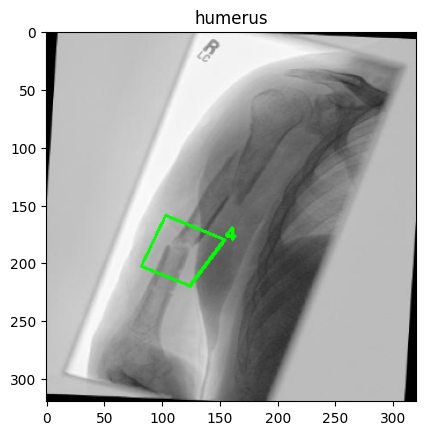

In [53]:
def unnormalize_bbox(image, coords):

    h, w, _ = image.shape
    # class_id, *coords = bbox
    print(coords)
    coords = np.array(coords).reshape(-1, 2)

    coords[:, 0] *= w
    coords[:, 1] *= h
    return coords


def plot_bbox(image, class_id,  bbox):
    coords = unnormalize_bbox(image, bbox)
    coords = coords.astype(int)
    for i in range(len(coords)):
        cv2.line(image, tuple(coords[i]), tuple(
            coords[(i + 1) % len(coords)]), (0, 255, 0), 2)
    cv2.putText(image, str(class_id), tuple(
        coords[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    plt.title(str(class_mapping[class_id]))
    plt.imshow(image)
    plt.show()


plot_bbox(cv2.resize(cv2.imread(images[15]),
          (320, 320)), class_ids[15], bboxes[15])

In [ ]:
# TODO: filterr images with label and skip if the  label/file is empty

class PrepareDataset:
    def __init__(self, image_dir: str, label_dir: str) -> None:

        self.images_path = [str(f)
                            for f in sorted(pathlib.Path(image_dir).glob('*.jpg'))]
        self.labels_path = [str(f)
                            for f in sorted(pathlib.Path(label_dir).glob('*.txt'))]

        # Ensure that you have same number of images and labels
        if len(self.images_path) != len(self.labels_path):
            raise ValueError(
                "Number of image files and label files do not match.")
        print(
            f'[INOF] Number of images:{len(self.images_path)} and labels:{len(self.labels_path)}')

    # def load_image(self, image_path: str):
    #     """Loads and preprocesses an image."""
    #     img = cv2.imread(image_path)  # Use cv2 for more image format support
    #     if img is None:
    #         raise ValueError(f"Could not read image: {image_path}")
    #     # Convert to RGB (TensorFlow default)
    #     # img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if needed
    #     # img = img / 255.0  # Normalize pixel values (important!)
    #     return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    def get_ploting_dataset(self):
        """Loads and parses YOLOv8 labels."""
        labels = []
        bboxes = []
        image_paths = []

        for image_pth, label_path in tqdm(zip(self.images_path, self.labels_path)):
            try:
                with open(label_path, 'r') as f:
                    lines = f.readlines()
            except FileNotFoundError:
                continue
            img = cv2.imread(image_pth)
            H, W, _ = img.shape

            for line in lines:
                # 0 0.458736435546875 0.3806510419921875 0.3614540244140625 0.389472591796875 0.36892872265625 0.48237111328125 0.457112263671875 0.471341630859375 0.458736435546875 0.3806510419921875
                try:
                    values = [value for value in line.split()]

                    # YOLO format is already normalized.
                    labels.append(int(values[0]))

                    x_center, y_center, w, h, *_ = map(float, values[1:])

                    # Bounding box koordinatlarını hesapla
                    x1 = int((x_center - w / 2) * W)
                    y1 = int((y_center - h / 2) * H)
                    x2 = int((x_center + w / 2) * W)
                    y2 = int((y_center + h / 2) * H)

                    bboxes.append(np.array([x1, y1, x2, y2]))
                    image_paths.append(image_pth)
                    print(bboxes)
                except:
                    continue

        # return (tf.ragged.constant(image_paths), tf.ragged.constant(labels), tf.ragged.constant(bboxes))
        return image_paths, labels, bboxes

    def get_dataset(self):
        """Loads and parses YOLOv8 labels."""
        labels = []
        bboxes = []
        image_paths = []

        for image_pth, label_path in tqdm(zip(self.images_path, self.labels_path)):
            try:
                with open(label_path, 'r') as f:
                    lines = f.readlines()
            except FileNotFoundError:
                continue

            for line in lines:
                # 0 0.458736435546875 0.3806510419921875 0.3614540244140625 0.389472591796875 0.36892872265625 0.48237111328125 0.457112263671875 0.471341630859375 0.458736435546875 0.3806510419921875
                try:
                    values = [float(value) for value in line.split()]
                    class_id = int(values[0])
                    coords = np.array(values[1:])

                    # YOLO format is already normalized.
                    labels.append(class_id)
                    bboxes.append(coords)
                    image_paths.append(image_pth)
                except:
                    continue

        return image_paths, labels, bboxes

### Training Dataset setup

In [ ]:
preparer_train_ds = PrepareDataset(image_dir=TRAIN_IMAGE_DIR,
                                   label_dir=TRAIN_LABELS_DIR)
image_paths_plt, labels_plt, bboxes_plt = preparer_train_ds.get_ploting_dataset()

In [ ]:
# bboxes_tensor = tf.ragged.constant(bboxes)
# classes_tensor = tf.ragged.constant(labels)
# image_paths_tensor = tf.ragged.constant(image_paths)

# train_data = tf.data.Dataset.from_tensor_slices(
#     (image_paths_tensor, classes_tensor, bboxes_tensor))
len(image_paths_plt), len(labels_plt), len(bboxes_plt)

In [ ]:
# valid_datasets = PrepareDataset(image_dir=VALID_IMAGE_DIR,
#                                 label_dir=VALID_LABELS_DIR)

# valid_ds = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(image_paths),
#                                                tf.ragged.constant(labels),
#                                                tf.ragged.constant(bboxes)))

In [ ]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    print(image.shape)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [ ]:
images_path = [cv2.imread(str(f))
               for f in sorted(pathlib.Path(TRAIN_IMAGE_DIR).glob('*.jpg'))]
# load_dataset(images_path[0], labels[0], bboxes[0])
images_path[0]

In [ ]:
idx = 50
class_idx = 1
image = cv2.cvtColor(images_path[idx], cv2.COLOR_BGR2RGB)
# image = cv2.resize(image, (320, 320))
bbox = bboxes_plt[idx]

In [ ]:
bbox[0], bbox[1], bbox[2], bbox[3]

In [ ]:
# image = cv2.resize(image, (320, 320))
height,  width, _ = image.shape

x, y, w, h = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])

# xmin, ymin, xmax, ymax = unconvert(width, height, x, y, w, h)
# print(xmin, ymin, xmax, ymax)
sp, ep = (x, y), (w, h)
_image = cv2.rectangle(image.copy(), sp, ep, (255, 0, 0), 2)


plt.imshow(_image)
plt.show()

In [ ]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
inputs = next(iter(train_ds.take(1)))
images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
image = images[0].numpy()
images[0].get_shape()